# Tarea 3: Recomendación

<a href="https://www.amazon.es/Hands-Unsupervised-Learning-Using-Python/dp/1492035645">Volver a Página Principal</a>

La tarea 3 consiste en hacer un motor de recomendación para 10.000 clientes a quienes les enviaremos un email con el producto que más les interese y que nos da mayores ganancias. Para ello, ordenaremos nuestros productos para cada cliente en función de sus preferencias. 

Adicionalmente, predeciremos la tasa de respuesta que obtendremos de los clientes y calcularemos el retorno de la inversión (ROI) o en su defecto el beneficio neto.

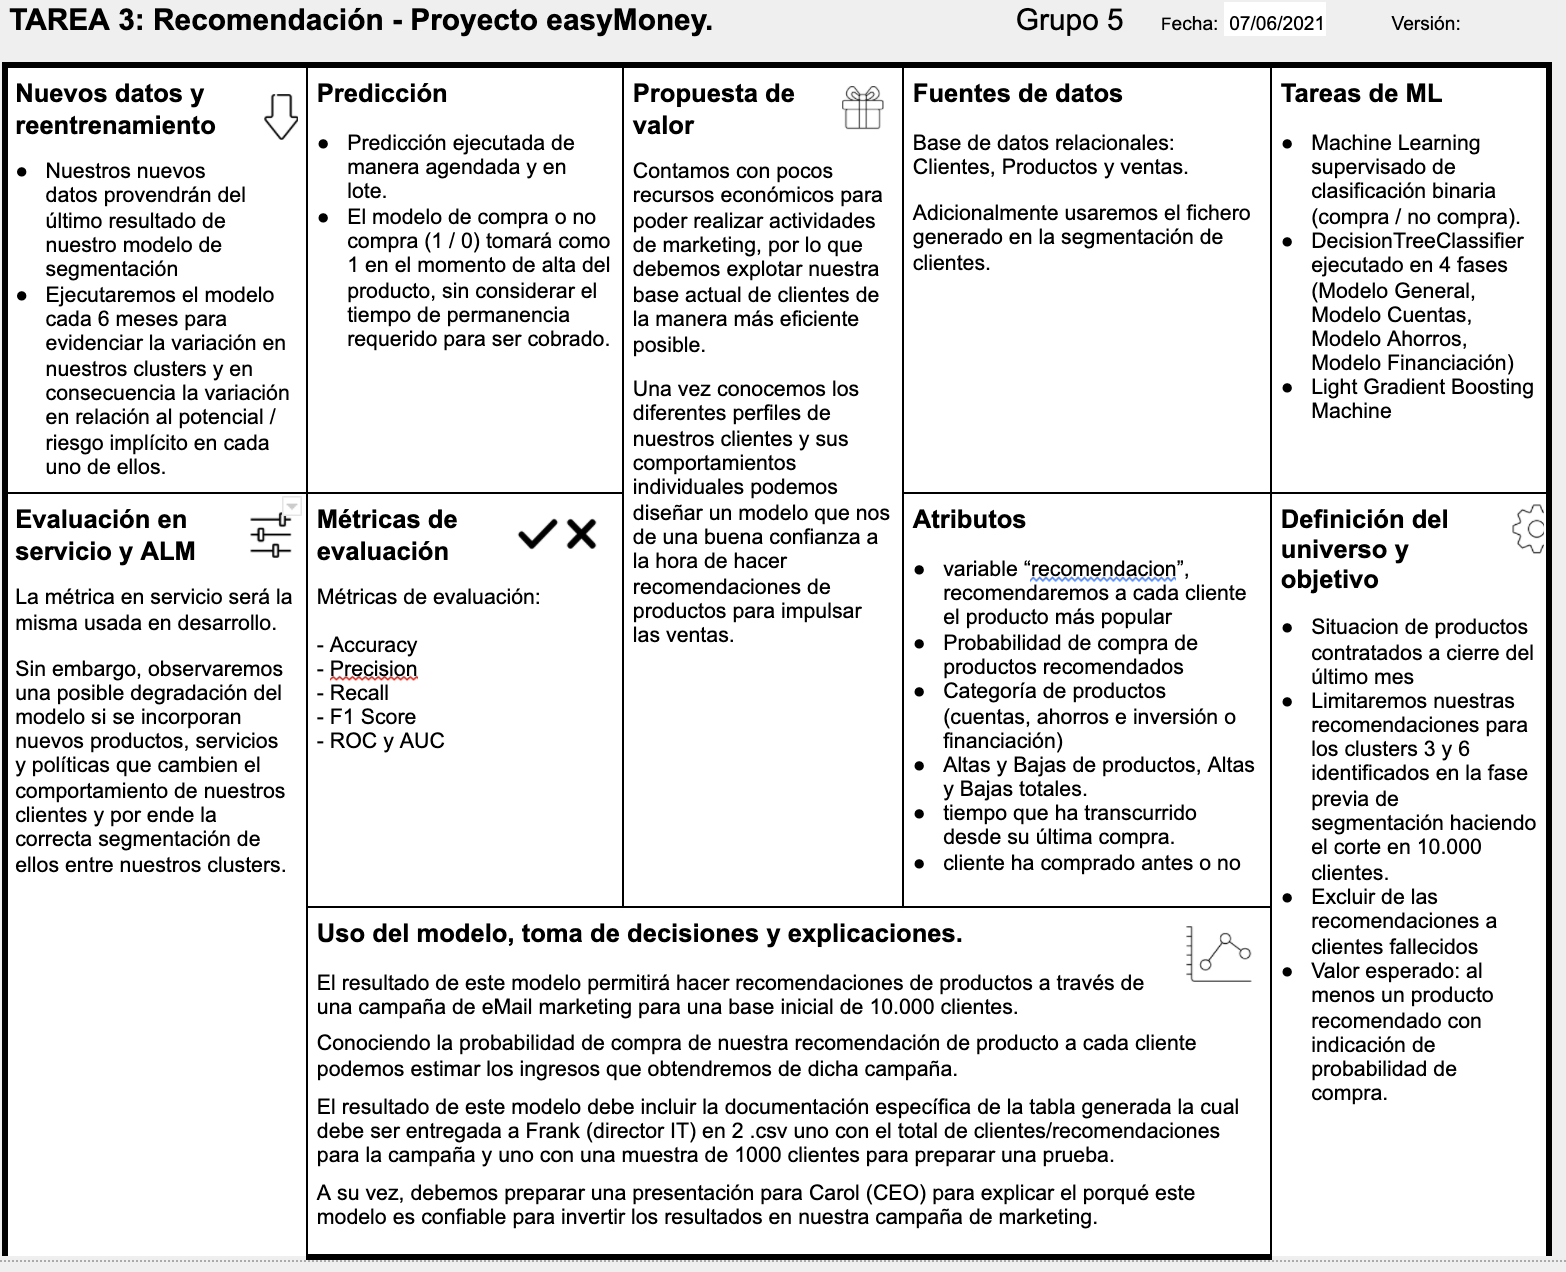

In [1]:
from IPython.display import Image
Image('./ML_canvas_3.png') 

## Tabla de Contenidos <a class="anchor" id="0"></a>

1. [Data Preparation](#origin) <br> 
    1.1. [Salario (salary)](#11) <br> 
    1.2. [Fallecido (deceased)](#12) <br> 
    1.3. [Cliente activo (active_customer)](#13) <br> 
    1.10. [Productos](#110) <br> 
2. [Data Cleaning](#2) <br> 
    2.1. [Feature Selection](#21) <br> 
    
3. [Selección de las recomendaciones](#3) <br> 
    3.1. [Beneficio neto esperado](#31) <br> 
    
4. [Preparación del dashboard](#4) <br> 
5. [Conclusiones](#5) <br>

#### Importación de librerías y dataset

In [70]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

import os

import warnings
warnings.filterwarnings("ignore")

# time calculation to track some processes
import time

import pickle

# import the function to compute cosine_similarity
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

import scipy as sp

In [71]:
PATH_DATA = "../input/easymoneygrupo5/"

Para el desarrollo del motor de recomendación utilizaremos el dataset de productos.

In [72]:
products = pd.read_csv(PATH_DATA+'products_df.csv', encoding='utf-8')
products.drop(columns=['Unnamed: 0'], inplace=True)

Hacemos una primera exploración del dataset. Tenemos para cada cliente y mes (o partición) los productos y servicios que tienen contratados.

In [73]:
products.head()

,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
0,1375586,2018-01-28,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
1,1050611,2018-01-28,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
2,1050612,2018-01-28,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
3,1050613,2018-01-28,1,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0
4,1050614,2018-01-28,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1


In [74]:
products.columns

Index(['pk_cid', 'pk_partition', 'short_term_deposit', 'loans', 'mortgage',
       'funds', 'securities', 'long_term_deposit', 'em_account_pp',
       'credit_card', 'payroll', 'pension_plan', 'payroll_account',
       'emc_account', 'debit_card', 'em_account_p', 'em_acount'],
      dtype='object')

# Data Preparation <a class="anchor" id="1"></a>

[Tabla de Contenidos](#0)

En esta sección se preparan y limpian los datos para poder realizar las recomendaciones.

In [75]:
# dataset con los clientes actuales y productos que tienen 
clientes_=products[products['pk_partition']=='2019-05-28']

In [76]:
# Borramos 'em_account_pp' porque siempre es cero y, por tanto, no aporta información. 
# Se excluye también payroll porque es un servicio y queremos evaluar los productos vendidos.

clientes_=clientes_[['pk_cid', 'short_term_deposit', 'loans', 'mortgage',
       'funds', 'securities', 'long_term_deposit',
       'credit_card', 'pension_plan', 'payroll_account',
       'emc_account', 'debit_card', 'em_account_p', 'em_acount']]

In [77]:
# el dataframe clientes_ incluye todos los clientes del último mes.
clientes_

,pk_cid,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
5519929,657826,0,0,0,0,0,0,0,0.0,0,0,0,0,1
5519930,657817,0,0,0,0,0,0,0,0.0,0,0,0,0,0
5519931,657986,0,0,0,0,0,0,1,1.0,1,1,1,0,0
5519932,657905,0,0,0,0,0,1,0,0.0,0,0,0,0,1
5519933,657336,0,0,0,0,0,0,0,0.0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5962919,1166765,0,0,0,0,0,0,0,0.0,0,0,0,0,1
5962920,1166764,0,0,0,0,0,0,0,0.0,0,0,0,0,1
5962921,1166763,0,0,0,0,0,0,0,0.0,0,0,0,0,1
5962922,1166789,0,0,0,0,0,0,0,0.0,0,0,0,0,1


In [78]:
# calculamos una columna total para saber el número de productos que tiene cada cliente con easyMoney
clientes_['total'] = clientes_.iloc[:,1:].sum(axis=1)

In [79]:
clientes_

,pk_cid,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,total
5519929,657826,0,0,0,0,0,0,0,0.0,0,0,0,0,1,1.0
5519930,657817,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0.0
5519931,657986,0,0,0,0,0,0,1,1.0,1,1,1,0,0,5.0
5519932,657905,0,0,0,0,0,1,0,0.0,0,0,0,0,1,2.0
5519933,657336,0,0,0,0,0,0,0,0.0,0,0,0,0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5962919,1166765,0,0,0,0,0,0,0,0.0,0,0,0,0,1,1.0
5962920,1166764,0,0,0,0,0,0,0,0.0,0,0,0,0,1,1.0
5962921,1166763,0,0,0,0,0,0,0,0.0,0,0,0,0,1,1.0
5962922,1166789,0,0,0,0,0,0,0,0.0,0,0,0,0,1,1.0


In [80]:
# dividimos el dataset entre los clientes que tienen actualmente productos contratados y los que no
clientes_productos=clientes_[clientes_["total"]>0]
clientes_productos

,pk_cid,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,total
5519929,657826,0,0,0,0,0,0,0,0.0,0,0,0,0,1,1.0
5519931,657986,0,0,0,0,0,0,1,1.0,1,1,1,0,0,5.0
5519932,657905,0,0,0,0,0,1,0,0.0,0,0,0,0,1,2.0
5519933,657336,0,0,0,0,0,0,0,0.0,0,0,0,0,1,1.0
5519935,658184,0,0,0,0,0,0,1,1.0,1,1,1,0,0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5962919,1166765,0,0,0,0,0,0,0,0.0,0,0,0,0,1,1.0
5962920,1166764,0,0,0,0,0,0,0,0.0,0,0,0,0,1,1.0
5962921,1166763,0,0,0,0,0,0,0,0.0,0,0,0,0,1,1.0
5962922,1166789,0,0,0,0,0,0,0,0.0,0,0,0,0,1,1.0


In [81]:
# los clientes que no tienen actualmente un producto contratado con nosotros
clientes_sin_productos=clientes_[clientes_["total"]==0]

In [82]:
clientes_sin_productos

,pk_cid,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,total
5519930,657817,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0.0
5519934,657147,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0.0
5519938,655419,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0.0
5519941,656942,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0.0
5519947,661894,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5962890,1166735,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0.0
5962892,1166733,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0.0
5962893,1166744,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0.0
5962896,1166762,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0.0


In [83]:
clientes_sin_productos.drop(["total"], axis=1, inplace=True)
clientes_productos.drop(["total"], axis=1, inplace=True)

In [84]:
# Recomendaremos los productos más populares, por lo tanto, hacemos un ranking de los productos más vendidos
# organizamos la base de datos con la que trabajaremos

In [85]:
clientes_productos=clientes_productos.melt(id_vars=["pk_cid"], value_name='valor', var_name='producto')

In [86]:
# reorganización del dataset
clientes_productos

,pk_cid,producto,valor
0,657826,short_term_deposit,0.0
1,657986,short_term_deposit,0.0
2,657905,short_term_deposit,0.0
3,657336,short_term_deposit,0.0
4,658184,short_term_deposit,0.0
...,...,...,...
4310639,1166765,em_acount,1.0
4310640,1166764,em_acount,1.0
4310641,1166763,em_acount,1.0
4310642,1166789,em_acount,1.0


In [87]:
# borramos los productos que no han contratado el cliente
clientes_conproductos=clientes_productos[clientes_productos['valor']==1]

In [88]:
clientes_conproductos.drop(['valor'], axis=1, inplace=True)

In [89]:
clientes_conproductos

,pk_cid,producto
214059,1090829,short_term_deposit
234422,1013549,short_term_deposit
346476,1339690,loans
352723,1398523,loans
356825,1395591,loans
...,...,...
4310639,1166765,em_acount
4310640,1166764,em_acount
4310641,1166763,em_acount
4310642,1166789,em_acount


In [90]:
# construimos un diccionario con los clientes y los productos que han comprado
lista_clientes_comprados=clientes_conproductos.groupby('pk_cid')['producto'].agg(list).to_dict()

In [91]:
# Recomendaremos los productos más populares, por lo tanto, hacemos un ranking de los productos más vendidos
# el orden coincide con el ranking considerando todo el historico

mas_populares=clientes_conproductos.groupby(['producto']).count()
mas_populares.columns=['ranking']
mas_populares=mas_populares.sort_values(by=['ranking'], ascending=False)

In [92]:
mas_populares

,ranking
producto,
em_acount,296380
debit_card,43261
payroll_account,26529
emc_account,24751
pension_plan,17353
long_term_deposit,6129
credit_card,4801
securities,1789
funds,1315


In [93]:
mas_populares=mas_populares.reset_index()
mas_populares['ranking1'] = mas_populares.index
mas_populares.drop(['ranking'], axis=1, inplace=True)
mas_populares['ranking']=mas_populares['ranking1']+1
mas_populares.drop(['ranking1'], axis=1, inplace=True)
mas_populares

,producto,ranking
0,em_acount,1
1,debit_card,2
2,payroll_account,3
3,emc_account,4
4,pension_plan,5
5,long_term_deposit,6
6,credit_card,7
7,securities,8
8,funds,9
9,loans,10


In [94]:
# diccionario con los top-ventas
top_ventas=pd.Series(mas_populares.ranking.values,index=mas_populares.producto).to_dict()

In [95]:
top_ventas

{'em_acount': 1,
 'debit_card': 2,
 'payroll_account': 3,
 'emc_account': 4,
 'pension_plan': 5,
 'long_term_deposit': 6,
 'credit_card': 7,
 'securities': 8,
 'funds': 9,
 'loans': 10,
 'mortgage': 11,
 'em_account_p': 12,
 'short_term_deposit': 13}

In [96]:
# la siguiente función asigna a cada cliente el producto más popular que no tenga contratado.

def clientes_recomendacion(lista_clientes, mi_top ):
    
    lcliente=[]
    lreco=[]

    for k, v in list(lista_clientes.items()):
        for k1, v1 in mi_top.items():
            if (k1 not in v and  k not in lcliente):
                lcliente.append(k)
                lreco.append(k1)
    lista_f=(lcliente, lreco)
    key_list = lista_f[0]
    value_list1 = lista_f[1]
    dict_from_list = {key_list[i]: value_list1[i] for i in range(len(key_list))}
    return dict_from_list

In [97]:
run = False
if run == True:
    recomendaciones = clientes_recomendacion(lista_clientes_comprados, top_ventas )

Guardamos la lista de recomendaciones por cliente en un pickle para no tener que volver a correr el código y, así, ahorrarnos tiempo

In [98]:
#guardar diccionario
#fichero = open("recomendaciones_data.pkl", "wb")
#pickle.dump(df_recomendacion, fichero)
#fichero.close()

In [99]:
# abrir el pickle
fichero = open(PATH_DATA+"recomendaciones_data.pkl", "rb")
output = pickle.load(fichero)

In [100]:
# pasamos el diccionario de clientes y recomendación a un df
df_recomendacion = pd.DataFrame([[key, output[key]] for key in output.keys()], columns=['pk_cid', 'recomendacion'])

In [101]:
df_recomendacion

,pk_cid,recomendacion
0,16203,debit_card
1,16502,debit_card
2,17457,payroll_account
3,17799,debit_card
4,17970,em_acount
...,...,...
331583,1553456,debit_card
331584,1553541,debit_card
331585,1553559,debit_card
331586,1553565,debit_card


In [102]:
# asignamos el top venta a los clientes que no tienen ningún producto contratado actualmente
clientes_sin_productos=clientes_sin_productos[['pk_cid']]

In [103]:
clientes_sin_productos['recomendacion']='em_acount'

In [104]:
clientes_sin_productos

,pk_cid,recomendacion
5519930,657817,em_acount
5519934,657147,em_acount
5519938,655419,em_acount
5519941,656942,em_acount
5519947,661894,em_acount
...,...,...
5962890,1166735,em_acount
5962892,1166733,em_acount
5962893,1166744,em_acount
5962896,1166762,em_acount


In [105]:
# unimos ambos dataframes. df_recomendacion contiene para cada cliente una recomendación de un producto
df_recomendacion=df_recomendacion.append(clientes_sin_productos)

Con el dataset df_recomendacion tenemos recomendaciones para toda nuestra base de clientes, pero solo tenemos presupuesto para 10.000 emails. Por lo tanto, seleccionaremos estos 10.000 clientes con base en sus intereses y los productos más rentables para easyMoney. Como explicamos anteriormente, haremos recomendaciones a los clientes que pertenecen a los clusters 3 (Los Curiosos) y 6 (Los Comprometidos) y escogeremos los que con mayor probabilidad nos compraran un producto.
Organizamos a continuación este dataset con los 10.000 clientes

In [106]:
client_segmentation = pd.read_csv('../input/easymoneygrupo5/client_segmentation.csv')
try: 
    client_segmentation.drop('Unnamed: 0',axis=1, inplace=True)
except: 
    pass

if client_segmentation['cluster'].min() == 0:
    client_segmentation['cluster'] += 1

client_segmentation.head()

,pk_cid,cluster
0,15891,2
1,16063,1
2,16203,2
3,16502,2
4,17457,4


In [107]:
client_segmentation["cluster"].value_counts().sort_index(ascending=True)

1    296891
2    109899
3     15698
4     14308
5      5593
6     13984
Name: cluster, dtype: int64

In [108]:
selected = [3,6]
df_reco_selected = client_segmentation[client_segmentation['cluster'].isin(selected)]
df_reco_selected = pd.merge(df_reco_selected, df_recomendacion.reset_index(), how='right', on='pk_cid')
df_reco_selected.set_index('pk_cid',inplace=True)

df_reco_selected = df_reco_selected.dropna(how='any')

print(df_reco_selected.head())
df_reco_selected.shape[0]

        cluster  index    recomendacion
pk_cid                                 
17970       6.0      4        em_acount
17980       6.0      5        em_acount
21719       3.0     15  payroll_account
26018       6.0     26       debit_card
28191       6.0     28        em_acount


29006

In [109]:
df_reco_selected["cluster"].value_counts().sort_index(ascending=True)

3.0    15499
6.0    13507
Name: cluster, dtype: int64

In [110]:
df_reco_selected.drop(['index'],axis=1,inplace=True)


In [111]:
df_reco_selected

,cluster,recomendacion
pk_cid,,
17970,6.0,em_acount
17980,6.0,em_acount
21719,3.0,payroll_account
26018,6.0,debit_card
28191,6.0,em_acount
...,...,...
1172676,6.0,em_acount
1164013,3.0,em_acount
1164712,6.0,em_acount


In [112]:
#guardar el dataset de df_reco_selected que contiene para los clusters 3 y 6 las recomendaciones de productos 
#fichero = open("reco_selected_data.pkl", "wb")
#pickle.dump(df_reco_selected, fichero)
#fichero.close()

In [113]:
products_dict = {"short_term_deposit":"ahorro e inversión", "loans":"financiación", "mortgage":"financiación", 
    "funds":"ahorro e inversión", "securities":"ahorro e inversión", "long_term_deposit":"ahorro e inversión", 
    "em_account_pp":"cuenta", "credit_card":"financiación", "payroll_account":"cuenta", "pension_plan":"ahorro e inversión", 
    "emc_account":"cuenta", "debit_card":"financiación", "em_account_p":"cuenta", "em_acount":"cuenta"}

cost_product = {'cuenta':10, 'ahorro e inversión':40, 'financiación':60}

In [114]:
df_reco_selected['tipo_producto'] = df_reco_selected['recomendacion'].replace(products_dict)
df_reco_selected['precio'] = df_reco_selected['tipo_producto'].replace(cost_product)
df_reco_selected.head()

,cluster,recomendacion,tipo_producto,precio
pk_cid,,,,
17970,6.0,em_acount,cuenta,10
17980,6.0,em_acount,cuenta,10
21719,3.0,payroll_account,cuenta,10
26018,6.0,debit_card,financiación,60
28191,6.0,em_acount,cuenta,10


# Selección de las recomendaciones <a class="anchor" id="XX"></a>

[Tabla de Contenidos](#0)

Tras obtener las recomendaciones, el siguiente paso es escoger que recomendaciones son las que mayor probabilidad de éxito tienen y que además generan mayor beneficio para la compañía. Para ello se construyó un Modelo de Compra que permite obtener la probabilidad de compra de cada cliente y cada producto recomendado, el desarrollo y construcción de este modelo puede visualizarse en <a href="./tarea3_modelo_compra.ipynb">Tarea 3: Modelo de Compra</a>. 

En la misma subtarea se preparan los datos para la predicción donde se tienen los registros y atributos de cada cliente en el siguiente mes.

In [115]:
prediccion_clientes = pd.read_csv('../input/easymoneygrupo5/clients_prediction.csv')
try:
    prediccion_clientes.drop('Unnamed: 0',axis=1,inplace=True)
except:
    pass

In [116]:
prediccion_clientes.drop('precio',axis=1,inplace=True)

In [117]:
recomendaciones_predict = pd.merge(df_reco_selected.reset_index(),  prediccion_clientes, how='left', on=['pk_cid'])
recomendaciones_predict.dropna(how='any',inplace=True)

A continuación se graba en una lista el orden de los features que deben ser entrados al modelo. Y se carga el modelo en un pickle, se ha optado por un Gradient Boosting Classifier en este caso por su versión de Light Gradient Boosting Machine.

In [118]:
filename = '../input/easymoneygrupo5/modelo_compra_general.sav'
model = pickle.load(open(filename, 'rb'))
model

LGBMClassifier(max_depth=50, min_child_samples=250, n_estimators=550,
               random_state=42)

In [119]:
features = model.feature_name_

In [120]:
X_predict = recomendaciones_predict.copy(deep=True)

cols = ['total_ahorros', 'compra_cuenta', 'total', 'total_cuenta', 'compra_ahorros', 'compra_financiacion', 'compra', 'total_financiacion']
#cols.append('pk_cid')
for x in cols:
    try:
        features.remove(x)
    except:
        pass
    
#features.remove('pk_cid')

X_predict = X_predict[features]

In [121]:
predictions = model.predict_proba(X_predict)[:,1]
recomendaciones_predict['prob'] = predictions

El siguiente paso es asegurarse que no se realizan recomendaciones a clientes fallecidos.

In [122]:
social = pd.read_csv(PATH_DATA+'sociodemographic_df.csv')
social = social.groupby('pk_cid').last()
social.reset_index(inplace=True)

In [123]:
recomendaciones_predict = pd.merge(recomendaciones_predict, social[['pk_cid','deceased']], how='left', on='pk_cid' )
recomendaciones_predict['deceased'].value_counts()

N    28641
S       17
Name: deceased, dtype: int64

In [124]:
recomendaciones_predict = recomendaciones_predict[recomendaciones_predict['deceased'] == 'N']

De todas las recomendaciones algunas son para productos de financiación, otras para productos de ahorros e inversión y otras para cuentas. Sin embargo, el beneficio de cada producto es diferente por lo que resulta interesante optar por los productos que mejor beneficio nos hacen obtener, pese a que el riesgo aumente (es decir que la probabilidad de compra disminuya). 

Para ello se separan las recomendaciones según el tipo de producto.

In [125]:
view_cols = ['pk_cid','recomendacion','precio','prob']

recomendaciones_predict = recomendaciones_predict.sort_values('prob',ascending=False)
recomendaciones_predict.head(10)

,pk_cid,cluster,recomendacion,tipo_producto,precio,entry_channel,active_customer,gender,age,salary,...,total_altas_3m_shift_age_tram_salary_tram_sum,total_altas_3m_shift_age_tram_salary_tram_mean,total_altas_1m_shift_fans_sum,total_altas_1m_shift_fans_mean,total_altas_2m_shift_fans_sum,total_altas_2m_shift_fans_mean,total_altas_3m_shift_fans_sum,total_altas_3m_shift_fans_mean,prob,deceased
10167,1262333,6.0,em_acount,cuenta,10,45.0,1.0,1.0,65.0,278488.23,...,729.0,1.564378,3373.0,1.180609,5311.0,1.315907,23804.0,1.000000,0.943965,N
25469,1521503,3.0,payroll_account,cuenta,10,61.0,1.0,0.0,28.0,-1.00,...,16864.0,1.568015,699.0,1.192833,1116.0,1.376079,17259.0,3.506501,0.922985,N
4711,1123897,6.0,em_acount,cuenta,10,45.0,1.0,1.0,59.0,208301.22,...,2291.0,1.571331,1194.0,1.158099,2096.0,1.318239,18042.0,2.000000,0.922660,N
15778,1383544,3.0,em_acount,cuenta,10,60.0,1.0,0.0,39.0,350267.25,...,6465.0,1.556331,699.0,1.192833,1116.0,1.376079,17259.0,3.506501,0.921572,N
24157,1503805,3.0,em_acount,cuenta,10,62.0,1.0,0.0,63.0,-1.00,...,1049.0,1.487943,16643.0,1.178599,38835.0,1.188924,0.0,0.000000,0.919101,N
10316,1264108,3.0,debit_card,financiación,60,45.0,1.0,0.0,40.0,91941.69,...,5786.0,1.537603,699.0,1.192833,1116.0,1.376079,17259.0,3.506501,0.918842,N
26374,1532075,3.0,em_acount,cuenta,10,61.0,1.0,1.0,20.0,-1.00,...,3442.0,1.592781,16643.0,1.178599,38835.0,1.188924,0.0,0.000000,0.918086,N
28162,1510318,3.0,em_acount,cuenta,10,62.0,1.0,1.0,22.0,-1.00,...,16864.0,1.568015,3373.0,1.180609,5311.0,1.315907,23804.0,1.000000,0.917647,N
7694,1218094,3.0,debit_card,financiación,60,44.0,1.0,1.0,41.0,97325.04,...,1996.0,1.609677,3373.0,1.180609,5311.0,1.315907,23804.0,1.000000,0.913494,N
6487,1174742,6.0,em_acount,cuenta,10,17.0,1.0,1.0,31.0,83533.95,...,5786.0,1.537603,699.0,1.192833,1116.0,1.376079,17259.0,3.506501,0.913371,N


In [126]:
reco_financiacion = recomendaciones_predict[ recomendaciones_predict['tipo_producto'] == 'financiación']
reco_financiacion[view_cols].sort_values('prob',ascending=False).head(10)

,pk_cid,recomendacion,precio,prob
10316,1264108,debit_card,60,0.918842
7694,1218094,debit_card,60,0.913494
12964,1345264,debit_card,60,0.901793
9109,1247125,debit_card,60,0.899939
4283,1117550,debit_card,60,0.896127
5296,1135627,debit_card,60,0.889244
24981,1516561,debit_card,60,0.885354
9348,1250791,debit_card,60,0.879039
4427,1119781,debit_card,60,0.876079
26576,1534614,debit_card,60,0.872460


In [127]:
reco_ahorros = recomendaciones_predict[ recomendaciones_predict['tipo_producto'] == 'ahorro e inversión']
reco_ahorros[view_cols].sort_values('prob',ascending=False).head(10)

,pk_cid,recomendacion,precio,prob
25735,1523901,long_term_deposit,40,0.814006
2735,1062835,long_term_deposit,40,0.761558
1249,1011517,long_term_deposit,40,0.736835
1868,1025022,pension_plan,40,0.735131
888,1002324,long_term_deposit,40,0.709442
4997,1128237,long_term_deposit,40,0.684435
10113,1261597,pension_plan,40,0.665397
10738,1271167,long_term_deposit,40,0.661515
1144,1008704,pension_plan,40,0.652620
13966,1369209,pension_plan,40,0.580641


In [128]:
reco_cuenta = recomendaciones_predict[ recomendaciones_predict['tipo_producto'] == 'cuenta']
reco_cuenta[view_cols].sort_values('prob',ascending=False).head(10)

,pk_cid,recomendacion,precio,prob
10167,1262333,em_acount,10,0.943965
25469,1521503,payroll_account,10,0.922985
4711,1123897,em_acount,10,0.922660
15778,1383544,em_acount,10,0.921572
24157,1503805,em_acount,10,0.919101
26374,1532075,em_acount,10,0.918086
28162,1510318,em_acount,10,0.917647
6487,1174742,em_acount,10,0.913371
24837,1514946,em_acount,10,0.909438
6986,1191540,em_acount,10,0.907530


El siguiente paso es definir los thresholds de probabilidad mínima que estamos dispuestos a aceptar. Es importante destacar que se ha impuesto el requerimiento de que tan sólo se puede realizar la recomendación de un produdcto a un cliente, por lo que un mismo cliente puede aparecer en los 3 tipos pero nos quedamos con tan solo una recomendación.

Los threshold que se tienen que entrar son más bajos de lo esperado, esto se debe a que al modelo el cuesta predecir compra o no compra y ante la duda decide ser conservador. Otro hecho es que la lista de recomendaciones tampoco es muy larga al reducir las recomendaciones tan sólo a los clusters 3 y 6; y estamos recomendando productos nuevos; una posible mejora sería recomendar productos a clientes que no lo tienen contratado pero lo han contratado anteriormente (existen varios clusters que tienen este comportamiento).

Añadir otro cluster hubiera hubiera sido un buen paso sin embargo las conversiones de los otros clusters eran muy lejanas a lo que se considera ideal. 

In [129]:
thres_financiacion = 0.25
thres_ahorros = 0.3
thres_cuenta = 0.3

N = reco_financiacion[reco_financiacion['prob']>thres_financiacion].shape[0]
M = reco_ahorros[reco_ahorros['prob']>thres_ahorros].shape[0]
L = reco_cuenta[reco_cuenta['prob']>thres_cuenta].shape[0]

print('Recomendaciones para financiación:', N)
print('Recomendaciones para ahorros:', M)
print('Recomendaciones para cuentas:', L)
print('Recomendaciones totales:', N+M+L)

Recomendaciones para financiación: 1709
Recomendaciones para ahorros: 22
Recomendaciones para cuentas: 9019
Recomendaciones totales: 10750


In [130]:
financiacion_selected = reco_financiacion[reco_financiacion['prob']>thres_financiacion].sort_values('prob',ascending=False)
financiacion_selected = financiacion_selected.groupby('pk_cid').first()
financiacion_selected.reset_index(inplace=True)

print(financiacion_selected.shape[0])
display(financiacion_selected[view_cols].sort_values('prob',ascending=False).head(10))

1709


,pk_cid,recomendacion,precio,prob
689,1264108,debit_card,60,0.918842
511,1218094,debit_card,60,0.913494
875,1345264,debit_card,60,0.901793
605,1247125,debit_card,60,0.899939
350,1117550,debit_card,60,0.896127
405,1135627,debit_card,60,0.889244
1512,1516561,debit_card,60,0.885354
624,1250791,debit_card,60,0.879039
357,1119781,debit_card,60,0.876079
1660,1534614,debit_card,60,0.872460


In [131]:
ahorros_selected = reco_ahorros[(reco_ahorros['prob']>thres_ahorros) & (~reco_ahorros['pk_cid'].isin(financiacion_selected['pk_cid']))].sort_values('prob',ascending=False)
#ahorros_selected.reset_index(inplace=True)
ahorros_selected = ahorros_selected.groupby('pk_cid').first()
ahorros_selected.reset_index(inplace=True)

print(ahorros_selected.shape[0])
display(ahorros_selected[view_cols].sort_values('prob',ascending=False).head(10))

22


,pk_cid,recomendacion,precio,prob
20,1523901,long_term_deposit,40,0.814006
8,1062835,long_term_deposit,40,0.761558
3,1011517,long_term_deposit,40,0.736835
4,1025022,pension_plan,40,0.735131
0,1002324,long_term_deposit,40,0.709442
10,1128237,long_term_deposit,40,0.684435
13,1261597,pension_plan,40,0.665397
14,1271167,long_term_deposit,40,0.661515
2,1008704,pension_plan,40,0.652620
19,1369209,pension_plan,40,0.580641


In [132]:
cuenta_selected = reco_cuenta[(reco_cuenta['prob']>thres_ahorros) & (~reco_cuenta['pk_cid'].isin(financiacion_selected['pk_cid'])) & (~reco_cuenta['pk_cid'].isin(ahorros_selected['pk_cid']))].sort_values('prob',ascending=False)
#cuenta_selected.reset_index(inplace=True)
cuenta_selected = cuenta_selected.groupby('pk_cid').first()
cuenta_selected.reset_index(inplace=True)

print(cuenta_selected.shape[0])
display(cuenta_selected[view_cols].sort_values('prob',ascending=False).head(10))

9019


,pk_cid,recomendacion,precio,prob
3095,1262333,em_acount,10,0.943965
7664,1521503,payroll_account,10,0.922985
1339,1123897,em_acount,10,0.922660
4493,1383544,em_acount,10,0.921572
6848,1503805,em_acount,10,0.919101
8395,1532075,em_acount,10,0.918086
7051,1510318,em_acount,10,0.917647
1900,1174742,em_acount,10,0.913371
7227,1514946,em_acount,10,0.909438
2055,1191540,em_acount,10,0.907530


In [133]:
final_reco = financiacion_selected.head(5000)
print('Tras añadir financiacion (60€): ',final_reco.shape[0])
final_reco = pd.concat( (final_reco, ahorros_selected.head(500)), ignore_index=True)
print('Tras añadir ahorros (40€): ',final_reco.shape[0])
final_reco = pd.concat( (final_reco, cuenta_selected.head( 10000 - final_reco.shape[0] )), ignore_index=True)
print('Tras añadir cuentas (10€): ',final_reco.shape[0])
final_reco[view_cols].sort_values('prob',ascending=False).head()

Tras añadir financiacion (60€):  1709
Tras añadir ahorros (40€):  1731
Tras añadir cuentas (10€):  10000


,pk_cid,recomendacion,precio,prob
4826,1262333,em_acount,10,0.943965
9395,1521503,payroll_account,10,0.922985
3070,1123897,em_acount,10,0.922660
6224,1383544,em_acount,10,0.921572
8579,1503805,em_acount,10,0.919101


In [134]:
final_reco['tipo_producto'].value_counts(normalize=True)

cuenta                0.8269
financiación          0.1709
ahorro e inversión    0.0022
Name: tipo_producto, dtype: float64

In [135]:
run = True
if run == True:
    final_reco[view_cols].to_csv('recomendaciones_finales.csv')

In [136]:
sample_recomendacion = final_reco[['pk_cid','recomendacion']].sample(1000).to_csv('sample_recomendaciones.csv')

## Beneficio neto esperado <a class="anchor" id="XX"></a>

[Tabla de Contenidos](#0)

En el email la responsable de Marketing Erin, nos pide si es posible el calcular el ROI. El <a href="https://www.40defiebre.com/que-es/roi">Return of Investment</a> se calcula como:

$$ROI = \frac{ Beneficio \; neto - Inversion }{Inversion}$$

La inversión únicamente se incluye el precio del emails, sin embargo este coste no para nada realista. A este coste deberían añadirsele los salarios de los trabajadores: copywriter, personal de marketing o el data scientist incluso (evaluados mensualmente); y los costes de sus ordenadores, etc. Para poder dar un valor de ROI realista.

Según <a href="https://mailchimp.com/pricing/marketing/">Mail Chimp</a> el precio aproximado para más de 50.000 contactos es de aproximadamente de 300€. Para una valor de inversión tan bajo aparece un ROI del 200%, muy pocas acciones tienen tal ROI en la vida real.

Es por ello que se refiere obtener el beneficio neto y en un futuro calcular la inversión que supone con más detalle. 

El beneficio neto se calcula como:

$$Beneficio \; neto [€] = \sum_j^{recomendaciones} probabilidad \; compra_j \cdot conversion_{cluster} \cdot precio \; producto_j $$

La fórmula anterior es una correcta aproximación del beneficio neto que se espera tras la campaña de email marketing. 

In [137]:
conversiones_worst = {3:0.33, 6:0.45}
conversiones_expected = {3:0.63, 6:0.74}
conversiones_best = {3:0.91, 6:1}

for cluster in conversiones_worst:
    final_reco['profit_worst'] = final_reco['cluster'].replace(conversiones_worst)*final_reco['precio']*final_reco['prob']

for cluster in conversiones_expected:
    final_reco['profit_expected'] = final_reco['cluster'].replace(conversiones_expected)*final_reco['precio']*final_reco['prob']
    
for cluster in conversiones_best:
    final_reco['profit_best'] = final_reco['cluster'].replace(conversiones_best)*final_reco['precio']*final_reco['prob']

En este caso se ofrecen 3 posibles casos, para ello se calculan las conversiones 25 cuartil, media y 75 cuartil de cada cluster; pudiendo así ofrecer el rango de valores en los que se espera que sea el beneficio neto con un worst case, expected case y best case. 

In [138]:
coste_emails = 300
print('Beneficio neto (worst case) [€]:',round(final_reco['profit_worst'].sum()/100)*100 - coste_emails)
print('Beneficio neto (expected case) [€]:',round(final_reco['profit_expected'].sum()/100)*100 - coste_emails)
print('Beneficio neto (best case) [€]:',round(final_reco['profit_best'].sum()/100)*100 - coste_emails)

Beneficio neto (worst case) [€]: 36700
Beneficio neto (expected case) [€]: 66300
Beneficio neto (best case) [€]: 93600


# Anexos

Aunque no utilizamos las siguientes técnicas porque no se aplican a nuestro problema por el tipo de datos que tenemos, mostramos a continuación cómo podríamos hacer una recomendación basada en la similitud entre productos o clientes a travésdel cálculo de la similitud del coseno item based y user based.

## Similitud del coseno

In [139]:
lista_columnas2= (['pk_cid', 'short_term_deposit', 'loans', 'mortgage',
       'funds', 'securities', 'long_term_deposit',
       'credit_card', 'pension_plan', 'payroll_account',
       'emc_account', 'debit_card', 'em_account_p', 'em_acount'])
lista_columnas2

['pk_cid',
 'short_term_deposit',
 'loans',
 'mortgage',
 'funds',
 'securities',
 'long_term_deposit',
 'credit_card',
 'pension_plan',
 'payroll_account',
 'emc_account',
 'debit_card',
 'em_account_p',
 'em_acount']

In [140]:
df_reco=products[lista_columnas2]
df_reco

,pk_cid,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
0,1375586,0,0,0,0,0,0,0,0.0,0,0,0,0,1
1,1050611,0,0,0,0,0,0,0,0.0,0,0,0,0,1
2,1050612,0,0,0,0,0,0,0,0.0,0,0,0,0,1
3,1050613,1,0,0,0,0,0,0,0.0,0,0,0,0,0
4,1050614,0,0,0,0,0,0,0,0.0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5962919,1166765,0,0,0,0,0,0,0,0.0,0,0,0,0,1
5962920,1166764,0,0,0,0,0,0,0,0.0,0,0,0,0,1
5962921,1166763,0,0,0,0,0,0,0,0.0,0,0,0,0,1
5962922,1166789,0,0,0,0,0,0,0,0.0,0,0,0,0,1


In [141]:
# Construimos el dataset de recomendación donde tendremos para cada cliente el tiempo (o las veces) que ha tenido cada producto en los 17 meses que tenemos información. 
df_reco_final=df_reco.pivot_table(index='pk_cid', aggfunc=[sum])
df_reco_final.head()

sum                                                            \
       credit_card debit_card em_account_p em_acount emc_account funds loans   
pk_cid                                                                         
15891            0          0            0         1           0     0     0   
16063            0          0            0         0           0     0     0   
16203            0          0            0         5           0     0     0   
16502            0          0            0         8           5     0     0   
17457            0          5            0        17           0     0     0   

                                                                           \
       long_term_deposit mortgage payroll_account pension_plan securities   
pk_cid                                                                      
15891                  0        0               0          0.0          0   
16063                  0        0               0          0.0          0   
16203                  0        0               0          0.0          0   
16502                  0        0               0          0.0          0   
17457                 16        0               0          0.0          0   

                           
       short_term_deposit  
pk_cid                     
15891                   0  
16063                   0  
16203                   0  
16502                   0  
17457                   0

In [142]:
df_reco_final.columns = df_reco_final.columns.droplevel()

In [143]:
# comprobamos que no hay nulos
df_reco_final.isnull().sum()

credit_card           0
debit_card            0
em_account_p          0
em_acount             0
emc_account           0
funds                 0
loans                 0
long_term_deposit     0
mortgage              0
payroll_account       0
pension_plan          0
securities            0
short_term_deposit    0
dtype: int64

In [144]:
# Tenemos 456.373 clientes y 13 productos.
df_reco_final.shape

(456373, 13)

Exploración del dataframe df_reco_final.

Observamos que uno de los productos más populares es em_account y la debit_card

In [145]:
df_reco_final.describe()

,credit_card,debit_card,em_account_p,em_acount,emc_account,funds,loans,long_term_deposit,mortgage,payroll_account,pension_plan,securities,short_term_deposit
count,456373.000000,456373.00000,456373.000000,456373.000000,456373.000000,456373.000000,456373.000000,456373.000000,456373.000000,456373.000000,456373.000000,456373.000000,456373.000000
mean,0.155281,1.23357,0.000075,9.600923,0.716434,0.044041,0.001025,0.220565,0.000710,0.721822,0.477246,0.048498,0.033731
std,1.378581,3.80113,0.035588,7.330076,3.194195,0.793736,0.116496,1.677957,0.104291,3.011529,2.305287,0.816721,0.320199
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.00000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.00000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,17.000000,17.00000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000


In [146]:
df_reco_final.head()

,credit_card,debit_card,em_account_p,em_acount,emc_account,funds,loans,long_term_deposit,mortgage,payroll_account,pension_plan,securities,short_term_deposit
pk_cid,,,,,,,,,,,,,
15891,0,0,0,1,0,0,0,0,0,0,0.0,0,0
16063,0,0,0,0,0,0,0,0,0,0,0.0,0,0
16203,0,0,0,5,0,0,0,0,0,0,0.0,0,0
16502,0,0,0,8,5,0,0,0,0,0,0.0,0,0
17457,0,5,0,17,0,0,0,16,0,0,0.0,0,0


In [147]:
# Para cada cliente sumamos la cantidad de producto que tiene contratados,
# borraremos aquellos clientes que no tienen ningún producto contratado pues no aportan información para hacer recomendaciones
df_reco_final['suma']=df_reco_final.sum(axis=1)

In [148]:
df_reco_final.drop(df_reco_final[df_reco_final["suma"]==0].index,axis=0,inplace=True)
df_reco_final.drop('suma', axis=1, inplace=True)

Luego de borrar los clientes sin productos contratados durantes los 17 meses, nos quedan 350.384 clientes.

In [149]:
df_reco_final.describe()

,credit_card,debit_card,em_account_p,em_acount,emc_account,funds,loans,long_term_deposit,mortgage,payroll_account,pension_plan,securities,short_term_deposit
count,350384.000000,350384.000000,350384.000000,350384.000000,350384.000000,350384.000000,350384.000000,350384.000000,350384.000000,350384.000000,350384.000000,350384.000000,350384.000000
mean,0.202252,1.606717,0.000097,12.505143,0.933150,0.057363,0.001336,0.287285,0.000925,0.940169,0.621609,0.063168,0.043935
std,1.570309,4.268450,0.040615,5.802179,3.617591,0.905444,0.132951,1.909989,0.119023,3.406969,2.613842,0.931602,0.364820
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000


In [150]:
df_reco_final.head()

,credit_card,debit_card,em_account_p,em_acount,emc_account,funds,loans,long_term_deposit,mortgage,payroll_account,pension_plan,securities,short_term_deposit
pk_cid,,,,,,,,,,,,,
15891,0,0,0,1,0,0,0,0,0,0,0.0,0,0
16203,0,0,0,5,0,0,0,0,0,0,0.0,0,0
16502,0,0,0,8,5,0,0,0,0,0,0.0,0,0
17457,0,5,0,17,0,0,0,16,0,0,0.0,0,0
17799,0,0,0,17,0,0,0,0,0,0,0.0,0,0


## Similitud del coseno para calcular similaridades entre productos comprados

Queremos recomendar productos a los clientes basado en los productos que tienen actualmente y considerando el tiempo que los ha tenido. La idea es hacer recomendaciones basada en la siguiente lógica: Los clientes que han tenido el producto X por muchos meses, también tienden a tener el producto Y por muchos meses, por lo tanto, los clientes que tienen X y no tienen Y se les recomendará el producto Y.

Para ello, nos basaremos en la similitud entre items calculada a través de la similitud del coseno.

Los primero que tenemos que hacer es normalizar el rango de las variables para evitar el efecto de escala, lo haremos usando MinMax Scale.

In [151]:
st = time.time()
df_reco_norm = df_reco_final.apply(lambda x: (x - np.min(x))/(np.max(x) - np.min(x)), axis = 1)
et = time.time()
print("Normalization took {} minutes".format(round((et - st)/60, 2)))

Normalization took 3.95 minutes


In [152]:
# Verificamos si se generaron ceros.
df_reco_norm.isnull().sum()

credit_card           0
debit_card            0
em_account_p          0
em_acount             0
emc_account           0
funds                 0
loans                 0
long_term_deposit     0
mortgage              0
payroll_account       0
pension_plan          0
securities            0
short_term_deposit    0
dtype: int64

In [153]:
# Se comprueba que los valores de los productos están normalizados entre 0 y 1.
df_reco_norm.describe()

,credit_card,debit_card,em_account_p,em_acount,emc_account,funds,loans,long_term_deposit,mortgage,payroll_account,pension_plan,securities,short_term_deposit
count,350384.000000,350384.000000,350384.000000,350384.000000,350384.000000,350384.000000,350384.000000,350384.000000,350384.000000,350384.000000,350384.000000,350384.000000,350384.000000
mean,0.013650,0.116691,0.000006,0.916081,0.066490,0.003726,0.000085,0.020866,0.000058,0.073456,0.048404,0.004299,0.006782
std,0.102318,0.287925,0.002389,0.257387,0.239349,0.057192,0.008318,0.134184,0.007270,0.247454,0.188528,0.060385,0.065733
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [154]:
# Escogemos una muestra aleatoria de 20000 observaciones porque con una cantidad superior se reinicia el kernel y nos da problema.
df_reco_norm2 = df_reco_norm.sample(20000)

In [155]:
# construimos una matriz sparse de datos para cada usuarios y los productos.
sparse_ratings = sp.sparse.csr_matrix(df_reco_norm2.values)

In [156]:
sparse_ratings

<20000x13 sparse matrix of type '<class 'numpy.float64'>'
	with 29154 stored elements in Compressed Sparse Row format>

In [157]:
item_similarity = cosine_similarity(sparse_ratings.T)

In [158]:
item_similarity_df = pd.DataFrame(item_similarity, index = df_reco_norm2.columns, columns = df_reco_norm2.columns)

In [159]:
# Obtenemos la matriz de similitud del coseno item based
item_similarity_df.head()

,credit_card,debit_card,em_account_p,em_acount,emc_account,funds,loans,long_term_deposit,mortgage,payroll_account,pension_plan,securities,short_term_deposit
credit_card,1.000000,0.247176,0.0,0.062518,0.195351,0.049484,0.000000,0.067617,0.000000,0.257673,0.257294,0.050306,0.005156
debit_card,0.247176,1.000000,0.0,0.274865,0.220550,0.033478,0.021204,0.055164,0.022618,0.490815,0.477440,0.074137,0.022491
em_account_p,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
em_acount,0.062518,0.274865,0.0,1.000000,0.151673,0.048581,0.007436,0.099885,0.000000,0.083038,0.067652,0.060201,0.065914
emc_account,0.195351,0.220550,0.0,0.151673,1.000000,0.109987,0.000000,0.233210,0.000000,0.213649,0.200164,0.090444,0.094990


La siguiente función extrae las top 5 recomendaciones de cada producto


In [160]:
def lista_recomendaciones(columna, df):
    top5=df[columna].sort_values(ascending=False)[1:6]
    recomendaciones_columna=top5.index
    recomendaciones_columna=recomendaciones_columna.tolist()
    return recomendaciones_columna 

In [161]:
# Para mirar los top 5 productos que se podrían recomendar a los clientes que tienen short_term_deposit:
recomendaciones_short_term_deposit=lista_recomendaciones('short_term_deposit', item_similarity_df)
recomendaciones_short_term_deposit

['long_term_deposit',
 'emc_account',
 'em_acount',
 'debit_card',
 'payroll_account']

## Recomendación User Based

Mostramos a continuación cómo podríamos calcular la similitud del coseno user based.

In [162]:
user_similarity = cosine_similarity(sparse_ratings)

user_similarity_df = pd.DataFrame(user_similarity, index = df_reco_norm2.index, columns = df_reco_norm2.index)

In [163]:
user_similarity_df.head()

pk_cid,1523531,1366381,1075258,1398156,1038032,1185880,1169227,1324009,1121631,1092669,...,1179770,1190340,1369429,1365346,419082,1394442,1277754,1103183,1185820,1518990
pk_cid,,,,,,,,,,,,,,,,,,,,,
1523531,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.887214,0.29361,0.0,0.172133,1.0,0.426401,0.707107,1.0
1366381,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.887214,0.29361,0.0,0.172133,1.0,0.426401,0.707107,1.0
1075258,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.887214,0.29361,0.0,0.172133,1.0,0.426401,0.707107,1.0
1398156,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.887214,0.29361,0.0,0.172133,1.0,0.426401,0.707107,1.0
1038032,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.887214,0.29361,0.0,0.172133,1.0,0.426401,0.707107,1.0


In [164]:
# La siguiente función muestra, para un cliente dado, 10 clientes similares a él basado en la similitud del coseno

def top_users(user, df):
    
    if user not in df.columns:
        return('No data available on user {}'.format(user))
    
    print('Most Similar Clients:\n')
    
    sim_users = df.sort_values(by = user, ascending=False).index[1:11]
    sim_values = df.sort_values(by = user, ascending=False).loc[:,user].tolist()[1:11]
    
    for user, sim in zip(sim_users, sim_values):
        print('User #{0}, Similarity value: {1:.2f}'.format(user, sim))

In [165]:
# La siguiente función muestra un dataframe con los top 5 productos de dos clientes:

def compare_2_users(user1, user2, df, nr_productos):

    top_10_user_1 = df[df.index == user1].melt().sort_values("value", ascending = False)[:nr_productos]
    top_10_user_1.columns = ["name_user_{}".format(user1), "rating_user_{}".format(user1)]
    top_10_user_1 = top_10_user_1.reset_index(drop = True)

    top_10_user_2 = df[df.index == user2].melt().sort_values("value", ascending = False)[:nr_productos]
    top_10_user_2.columns = ["name_user_{}".format(user2), "rating_user_{}".format(user2)]
    top_10_user_2 = top_10_user_2.reset_index(drop = True)

    combined_2_users = pd.concat([top_10_user_1, top_10_user_2], axis = 1, join = "inner")
    
    return combined_2_users

In [166]:
user1 = 1072201
user2 = 1446542

In [167]:
combined_2_users = compare_2_users(user1, user2, df_reco_final, 5)
combined_2_users

,name_user_1072201,rating_user_1072201,name_user_1446542,rating_user_1446542
0,em_acount,12.0,emc_account,9.0
1,debit_card,8.0,payroll_account,9.0
2,payroll_account,5.0,pension_plan,6.0
3,credit_card,0.0,debit_card,3.0
4,em_account_p,0.0,credit_card,0.0


In [168]:
top_users(1216199, user_similarity_df)

'No data available on user 1216199'